# Environmental noise classification

### The task is to classify different environmenal noises (bus station, wasching machine etc...)

In [1]:
import numpy as np
import scipy.io.wavfile
import matplotlib.pyplot as plt
import librosa
import os
from statistics import mode

In [2]:
PATH = 'database'
PATH_TEST = 'test_data'
NUM_OF_CLASSES = 26
ticks = ['blender', 'bus', 'bus stop', 'cafeteria', 'coffee machine', 'dish washer', 'electric razor', \
         'food processor', 'footsteps', 'hair dryer', 'library', 'listening music', 'listening radio', \
         'living room TV', 'metro', 'microwave', 'microwave bell', 'microwave door', 'office', 'train', \
         'train station' ,'vacuum cleaner', 'washing machine', 'watching TV', 'water boiler', 'water tap']

ticks_conf_matrix = ['blender', 'bus', 'bus stop', 'cafeteria', 'coffee machine', 'dish washer', \
                     'electric razor', 'food processor', 'footsteps', 'hair dryer', 'library', \
                     'listening music', 'listening radio', 'living room TV', 'metro', 'microwave', \
                     'microwave bell', 'microwave door', 'train', 'vacuum cleaner', 'washing machine', \
                     'watching TV', 'water boiler', 'water tap']

In [3]:
print (40*'-')
print ('Extracting MFCC features...')
print (40*'-')
    
# extract MFCC features from training data and assign true labels
trainingData = np.empty([0, 13])
trainingLabels = np.empty([0,1])
lab = 0
for category in os.listdir(PATH):
    if category != '.DS_Store':
        lab = lab + 1
        for file in os.listdir(PATH +'/'+ category):
            if file.endswith(".wav"):
                sampling_rate, signal = scipy.io.wavfile.read(PATH +'/'+ category+'/'+file)
                if signal.ndim == 2:
                    signal = signal[:, 0]
                signal = np.array(signal, dtype=float)
                mfcc = librosa.feature.mfcc(y=signal, sr=sampling_rate, n_mfcc=13)
                labels = np.empty((mfcc.shape[1], 1))
                labels.fill(int(lab))
                trainingData = np.concatenate((trainingData, mfcc.T), axis=0)
                trainingLabels = np.concatenate((trainingLabels, labels), axis=0)

print ('Numer of training data: {}'.format(trainingData.shape[0]))
print ('Numer of MFCCs: {}'.format(trainingData.shape[1]))


----------------------------------------
Extracting MFCC features...
----------------------------------------


/Users/agnieszka/anaconda/lib/python3.6/site-packages/scipy/io/wavfile.py:273: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)


Numer of training data: 368028
Numer of MFCCs: 13


In [6]:
print (40*'-')
print ('Training KNN classifier...')
print (40*'-')

# Train KNN classifier
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=3)
neigh.fit(trainingData, trainingLabels.ravel())

print (30*'-')
print ('Predicting test data...')
print (30*'-')

# Predict test data
trueLabels = np.empty([0,1])
predictedLabels = np.empty([0,1])
lab = 0
for category in os.listdir(PATH_TEST):
    if category != '.DS_Store':
        lab = lab + 1
        directory = PATH_TEST +'/'+ category
        if os.listdir(directory):
            for file in os.listdir(directory):
                testData = np.empty([0, 13])
                testLabels = np.empty([0,1])
                if file.endswith(".wav"):
                    sampling_rate, signal = scipy.io.wavfile.read(directory + '/'+file)
                    if signal.ndim == 2:
                        signal = signal[:, 0]
                    signal = np.array(signal, dtype=float)
                    mfcc = librosa.feature.mfcc(y=signal, sr=sampling_rate, n_mfcc=13)
                    labels = np.empty((mfcc.shape[1], 1))
                    labels.fill(int(lab))
                    testData = np.concatenate((testData, mfcc.T), axis=0)
                    testLabels = np.concatenate((testLabels, labels), axis=0)
            trueLabels = np.concatenate((trueLabels, testLabels), axis = 0)
            prediction = neigh.predict(testData)
            label_big = mode(prediction)
            predictedLabels = np.concatenate((predictedLabels,
                                              prediction.reshape((prediction.shape[0], 1))), axis = 0)
            print ('True label:        {}'.format(ticks[int(lab)-1]))
            print ('Predicted label:   {}'.format(ticks[int(label_big)-1]))
            print (40*'-')

acc = np.sum(trueLabels == predictedLabels)/trueLabels.shape[0]
print ('KNN classifier accuracy: {}'.format(acc))

----------------------------------------
Training KNN classifier...
----------------------------------------
------------------------------
Predicting test data...
------------------------------
True label:        blender
Predicted label:   blender
----------------------------------------


/Users/agnieszka/anaconda/lib/python3.6/site-packages/scipy/io/wavfile.py:273: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)


True label:        bus
Predicted label:   metro
----------------------------------------
True label:        bus stop
Predicted label:   bus stop
----------------------------------------
True label:        cafeteria
Predicted label:   cafeteria
----------------------------------------
True label:        coffee machine
Predicted label:   watching TV
----------------------------------------
True label:        dish washer
Predicted label:   coffee machine
----------------------------------------
True label:        electric razor
Predicted label:   electric razor
----------------------------------------
True label:        food processor
Predicted label:   food processor
----------------------------------------
True label:        footsteps
Predicted label:   vacuum cleaner
----------------------------------------
True label:        hair dryer
Predicted label:   hair dryer
----------------------------------------
True label:        library
Predicted label:   library
--------------------------

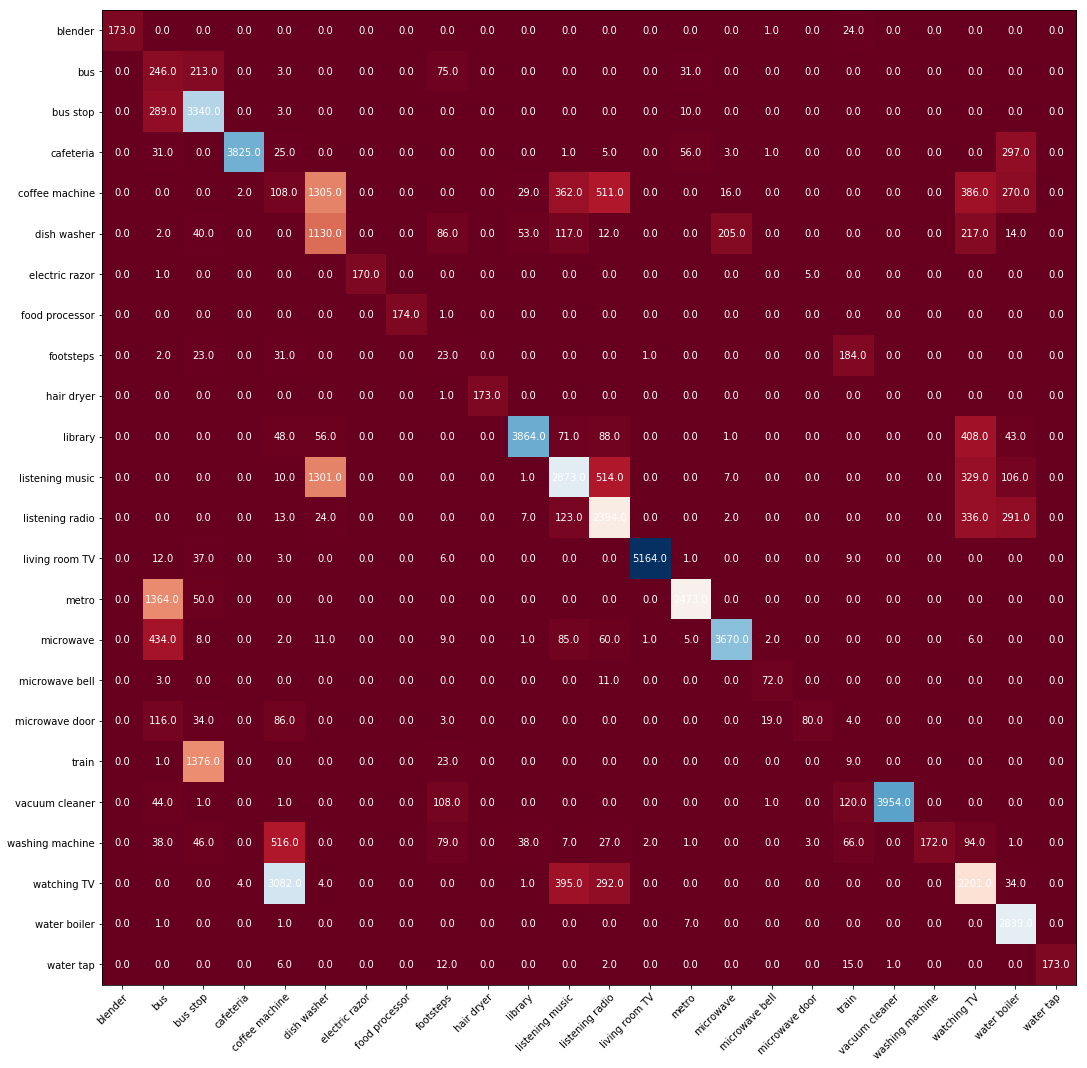

In [5]:
# Visualize prediction results as confusion matrix
conf_matrix = np.zeros([NUM_OF_CLASSES, NUM_OF_CLASSES])
for i in range(predictedLabels.shape[0]):
    conf_matrix[int(predictedLabels[i])-1,int(trueLabels[i])-1] = conf_matrix[int(predictedLabels[i])-1,
                                                                              int(trueLabels[i])-1] + 1

conf_matrix_rows_del = np.delete(conf_matrix,[18,20], 0)
conf_matrix_cols_del = np.delete(conf_matrix_rows_del,[18,20], 1)

fig, ax = plt.subplots(figsize = (15,15))
im = ax.imshow(conf_matrix_cols_del, cmap=plt.cm.RdBu)
ax.set_xticks(np.arange(len(ticks_conf_matrix)))
ax.set_yticks(np.arange(len(ticks_conf_matrix)))
ax.set_xticklabels(ticks_conf_matrix)
ax.set_yticklabels(ticks_conf_matrix)

plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

for i in range(len(ticks_conf_matrix)):
    for j in range(len(ticks_conf_matrix)):
        text = ax.text(j, i, conf_matrix_cols_del[i, j], ha="center", va="center", color="w")

fig.tight_layout()
plt.show()